<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/assignment_2_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Add libraries

In [1]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import zipfile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

### Path system

In [2]:
# you need the current working directory NB: works both windows and linux
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(*['..', current_working_directory, 'Datasets', 'weather_dataset'])
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is /Datasets/weather_dataset


### function for data loading

In [3]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list()
        # let s loop here and we try to discover how many class we have
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")

            # add the list to nam _list
            name_of_the_labels.append(class_name)

            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])

                # add the class number
                labels.append(class_number)

                if target_size is None:
                    # let s load the image
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)

                # transform PIL object in image
                image = tf.keras.utils.img_to_array(image)

                # add the image to the ds list
                dataset.append(image)

        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

### OHE function

In [4]:
# here we have to one hot encode the labes
def make_the_one_hot_encoding(labels_to_transform):
    try:
        enc = OneHotEncoder(handle_unknown='ignore')
        # this is a trick to figure the array as 2d array instead of list
        temp = np.reshape(labels_to_transform, (-1, 1))
        labels_to_transform = enc.fit_transform(temp).toarray()
        print(f'[ONE HOT ENCODING] Labels are one-hot-encoded: {(labels_to_transform.sum(axis=1) - np.ones(labels_to_transform.shape[0])).sum() == 0}')
        return labels_to_transform
    except Exception as ex:
        print(f"[EXCEPTION] Make the one hot encoding throws exception {ex}")

### load the data and labels

In [5]:
from google.colab import files
#uploaded = files.upload()

In [6]:
url = "https://seafile.utu.fi/f/88c08f841e0348e1a412/?dl=1"
zip_path = "/content/weather_dataset.zip"
urllib.request.urlretrieve(url, zip_path)

('/content/weather_dataset.zip', <http.client.HTTPMessage at 0x7c4371928090>)

In [7]:
extract_path = "/content/weather_dataset"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

In [8]:
dataset, labels, class_names = load_the_data_and_the_labels("/content/weather_dataset/weather_dataset", target_size=(224, 224))

[WALK] I am walking into /content/weather_dataset/weather_dataset/Sunrise
[WALK] I am walking into /content/weather_dataset/weather_dataset/Shine
[WALK] I am walking into /content/weather_dataset/weather_dataset/Cloudy
[WALK] I am walking into /content/weather_dataset/weather_dataset/Rain


### normalize the data

In [9]:
# Normalize images
dataset = dataset / 255.0

In [10]:
encoded_labels = make_the_one_hot_encoding(labels)

[ONE HOT ENCODING] Labels are one-hot-encoded: True


### split the dataset in train and test set (ratio 0.3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size=0.3, stratify=labels)

### create the CNN and set all parameters to trainable
a.	Input layer
b.	As base model use VGG19:
    i.	Weights: imagenet
    ii.	Include_top: False
    iii.	Input_shape the target shape described in point 1.
c.	Add a flatten layer
d.	Add a Dense layer with 512 units and a dropout layer with 0.1 unit.
e.	Add a Dense layer with 256 units and a dropout layer with 0.1 unit.
f.	Add the final classifier with the correct number of units and the suitable activation.


In [12]:
def cnn_vgg19(input_shape=(224, 224, 3), num_classes=4):
    #a
    input_layer = Input(shape=input_shape)
    #b
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)
    #base_model.trainable = True #This makes only the last layer trainable
    for layer_ctn, layer in enumerate(base_model.layers[:]): layer.trainable = True # / False #This makes all layesrs trainable
    #c
    flatten_layer = Flatten()(base_model.output)
    #d
    dense = Dense(512, activation='relu')(flatten_layer)
    dropout = Dropout(0.1)(dense)
    #e
    dense2 = Dense(256, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    #f
    output_layer = Dense(num_classes, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [13]:
model = cnn_vgg19()
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,002,308 (125.89 MB)

 Trainable params: 33,002,308 (125.89 MB)

 Non-trainable params: 0 (0.00 B)

### compile the model with adam

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Fit the model with batch size 32 and 15 epochs (This take 15 - 20 minutes with the CPU)

In [15]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.2859 - loss: 8.2884 - val_accuracy: 0.3166 - val_loss: 1.3459
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 644ms/step - accuracy: 0.3317 - loss: 1.3687 - val_accuracy: 0.3669 - val_loss: 1.3694
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 652ms/step - accuracy: 0.3072 - loss: 1.3488 - val_accuracy: 0.3166 - val_loss: 1.3791
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 625ms/step - accuracy: 0.2968 - loss: 1.3783 - val_accuracy: 0.3166 - val_loss: 1.3722
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 619ms/step - accuracy: 0.3513 - loss: 1.3630 - val_accuracy: 0.3166 - val_loss: 1.3693
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 625ms/step - accuracy: 0.3135 - loss: 1.3673 - val_accuracy: 0.3166 - val_loss: 1.3691
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 629ms/step - accuracy: 0.3106 - loss: 1.3684 - val_accuracy: 0.3166 - val_loss: 1.3691
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 626ms/step - accuracy: 0.2963 - loss: 1.3834 - val_accura

### Evaluate  the model

In [16]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.3040 - loss: 1.3696


[1.3691591024398804, 0.3165680468082428]

#### Make and show predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step


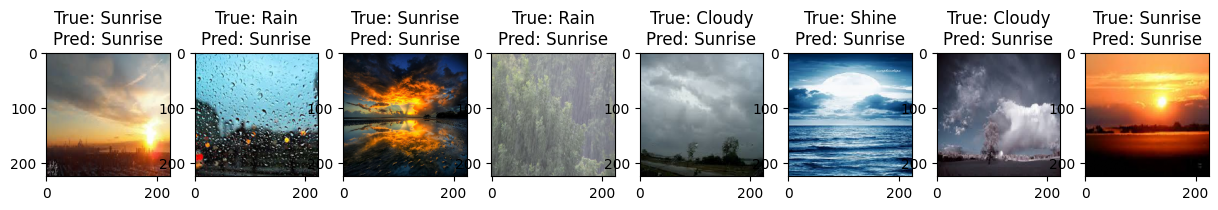

In [17]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
def plot_predictions(images, true_labels, predicted_labels, class_names, num_images=8):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
plot_predictions(X_test, true_classes, predicted_classes, class_names)

### make confusion matrix

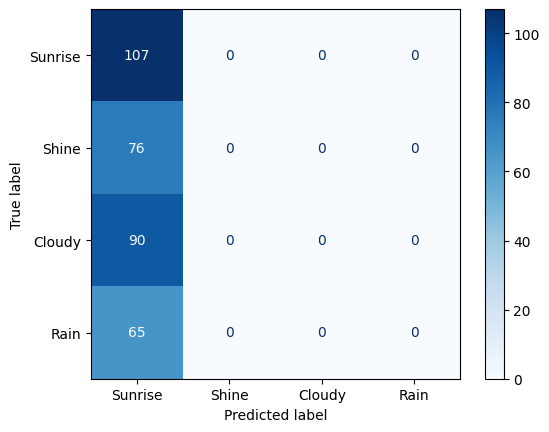

In [18]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

### Load again the cnn but this time set the parameters to NOT TRAINABLE

In [19]:
def cnn_vgg19_non_trainable(input_shape=(224, 224, 3), num_classes=4):
    input_layer = Input(shape=input_shape)
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)
    #base_model.trainable = False #THis makes only the last layer untrainable
    for layer_ctn, layer in enumerate(base_model.layers[:]): layer.trainable =False # True / False #This makes all layers trainable
    flatten_layer = Flatten()(base_model.output)
    dense = Dense(512, activation='relu')(flatten_layer)
    dropout = Dropout(0.1)(dense)
    dense2 = Dense(256, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    output_layer = Dense(num_classes, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

### Fit the model with batch size 32 and 15 epochs (This is fsaster)

In [20]:
model2 = cnn_vgg19_non_trainable()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 822ms/step - accuracy: 0.3572 - loss: 4.1277 - val_accuracy: 0.7367 - val_loss: 0.6186
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.7431 - loss: 0.6459 - val_accuracy: 0.8698 - val_loss: 0.3578
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.8955 - loss: 0.2961 - val_accuracy: 0.8550 - val_loss: 0.3327
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.9480 - loss: 0.1720 - val_accuracy: 0.8876 - val_loss: 0.2814
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - accuracy: 0.9717 - loss: 0.1041 - val_accuracy: 0.9142 - val_loss: 0.2715
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - accuracy: 0.9753 - loss: 0.0797 - val_accuracy: 0.8787 - val_loss: 0.3466
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step - accuracy: 0.9780 - loss: 0.0667 - val_accuracy: 0.8876 - val_loss: 0.3673
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.9813 - loss: 0.0535 - val_accurac

# Evaluate the model

In [21]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.9109 - loss: 0.2753


### Make and show some predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step


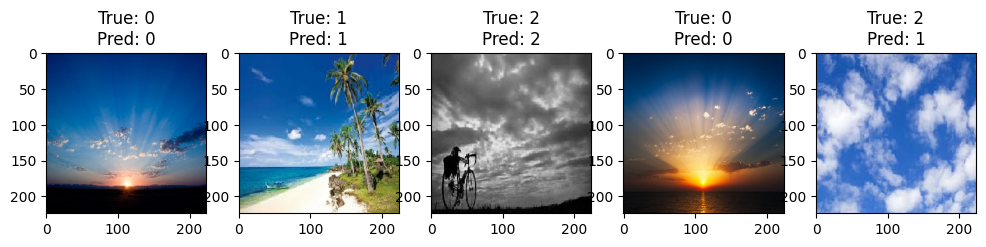

In [22]:
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[idx])
    true_label = y_true_classes[idx]
    pred_label = y_pred_classes[idx]
    plt.title(f"True: {true_label}\nPred: {pred_label}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step


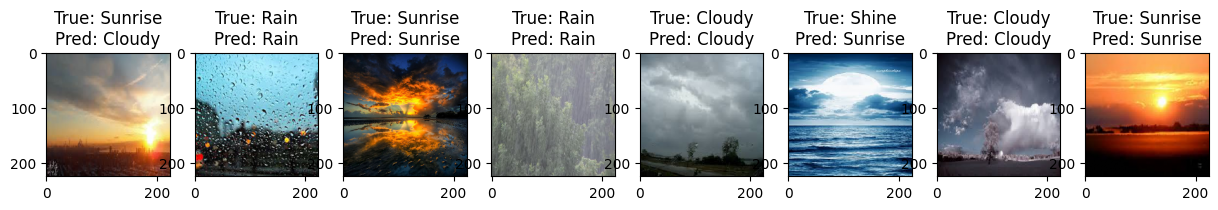

In [23]:
predictions = model2.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
def plot_predictions(images, true_labels, predicted_labels, class_names, num_images=8):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
plot_predictions(X_test, true_classes, predicted_classes, class_names)